# Before getting started

- **Use a GPU runtime.** This will make training neural networks much faster (but it will restart your runtime). You can do this by clicking on:
> Runtime > Change runtime type > Hardware accelerator - *select GPU and save*

- **Install some packages.** We will use `fastai` which is built atop `pytorch`, a popular deep learning framework. Unfortunately, these libraries have other dependencies (like CUDA, the language that the GPU speaks) and can take a while to install.

- **Download image files.** Using deep neural networks, we can learn directly from individual pixels in multi-channel images. We will be using xGASS images in JPG format from the Sloan Digital Sky Survey.

In [ ]:
# fastai is a high-level deep learning library built on Pytorch
!pip install -q fastai --upgrade

from fastai.basics import *
from fastai.tabular.all import *
from fastai.vision.all import *

# get xGASS catalog
!wget -q -nc -O xGASS_representative_sample.csv https://www.dropbox.com/s/hd81uq75gsm6i0z/xGASS_representative_sample.csv

# get and untar xGASS images
!wget -q -nc -O images-xGASS.tar.gz https://www.dropbox.com/s/0c3dp4dt3tlfjl8/images-xGASS.tar.gz
!tar xzf images-xGASS.tar.gz 

In [ ]:
# note: you can also check your GPU using this command:
!nvidia-smi

Thu Oct 13 20:18:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# The story so far...

Last time, we were able to estimate the HI gas-to-stellar mass fraction, $\log (M_{\rm HI}/M_\star)$, for the xGASS galaxy sample. We used a combination of photometric and morphological parameters in order to regress against the gas mass fraction `lgGF`.

Here's a few examples from of our data set
```   
GASS    model_r   NUVr    expAB_r     petrR50_r  CINDX   INCL    lgGF     
----------------------------------------------------------------------                       
108064  14.6820   2.30    0.347443    7.51       2.52    73.1   -0.082
  3504  15.4495   2.81    0.939227    8.53       1.84    20.5   -0.512
112116  15.1316   1.69    0.614720    3.23       2.42    53.6   -0.682
111013  13.8649   2.71    0.791741    8.47       2.34    38.6   -0.669
 52045  15.5552   2.08    0.961924    3.97       2.38    16.2   -0.403
```

Both a [polynomial model](https://colab.research.google.com/drive/1MxWjF1vdBF3ArQ6WAR3meV-ytNOVnIOr#scrollTo=pl0yVoBjorKZ) and a [random forest model](https://colab.research.google.com/drive/1MxWjF1vdBF3ArQ6WAR3meV-ytNOVnIOr#scrollTo=f8eoi_cZBe2H) performed reasonably well; we identified that the $NUV - r$ color was particularly important for achieving low error (0.29 dex).

# Can we predict a galaxy's neutral hydrogen (HI) content *using images*?

What if we used the color and morphological information *purely from images* to estimate the logarithmic gas mass fraction? We know that this method will be weaker, because we won't be using the $u$-band or $GALEX$ imaging. Instead, we will simply take $gri$ image cutouts from SDSS, using the [REST API described here](http://skyserver.sdss.org/dr16/en/help/docs/api.aspx).

These images have already been downloaded for the 1197 galaxies and saved in a tar file; if you ran the first line of code above, then you should have the images saved in a folder `images-xGASS/`.

Our directory structure should look something like this:

```
.
├── xGASS_representative_sample.csv
├── images-xGASS
│   ├── 10005.jpg
│   ├── 10010.jpg
│   └── [...]
└── [this notebook.ipynb]
```



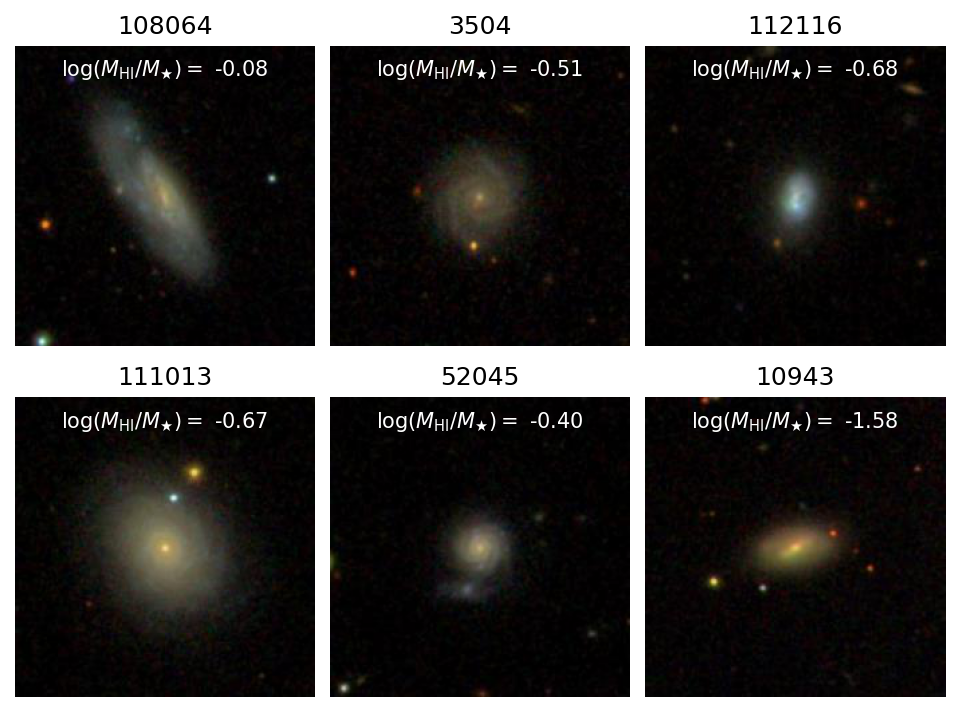

In [ ]:
df = pd.read_csv('xGASS_representative_sample.csv')
n_galaxies = len(df)

np.random.seed(42)

# view nine random galaxies and display their gas mass fractions
fig, axes = plt.subplots(2, 3, figsize=(8, 6), dpi=150)
for i, ax in zip(np.random.choice(range(n_galaxies), size=9, replace=False), axes.flat):

    gass_id = df.GASS.iloc[i]
    PILImage.create(f'images-xGASS/{gass_id}.jpg').show(ax=ax, title=gass_id)

    lgGF = df.lgGF.iloc[i]
    ax.text(0.5, 0.9, r'$\log(M_{\rm HI}/M_★) = $ ' f'{lgGF:.2f}', ha='center', transform=ax.transAxes, color='white')

fig.subplots_adjust(wspace=0.05, hspace=0.07)

# Yes, with Convolutional Neural Networks (CNNs)!

First we'll show a CNN in action, and then we'll cover the details. These results are similar to the ones presented in [Wu (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...900..142W/abstract), except with a much smaller data set.

PS - I also provide a brief overview of how to use the Fastai API in a [blog post](https://jwuphysics.github.io/blog/galaxies/astrophysics/deep%20learning/computer%20vision/fastai/2020/05/26/training-a-deep-cnn.html).

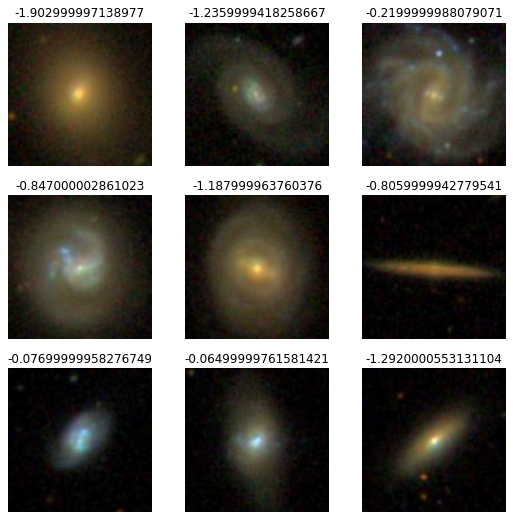

In [ ]:
# fastai "data blocks" determine how data can be fed into a model
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('GASS', pref='images-xGASS/', suff='.jpg'),
    get_y=ColReader('lgGF'),
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=CropPad(128),
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1.0, max_warp=0, p_lighting=0) + [Normalize()]
)

# "data loaders" actually load the data 
dls = ImageDataLoaders.from_dblock(dblock, df)
dls.show_batch()

In [ ]:
# root mean squared error is our loss function
def RMSE(p, y): return torch.sqrt(MSELossFlat()(p, y))

# this is a reasonably deep CNN model
cnn_model = xresnet18(n_out=1)

# a "learner" evaluates and updates the model 
learn = Learner(
    dls,
    cnn_model,
    loss_func=RMSE,
    opt_func=Adam,
    metrics=[R2Score()]
)

SuggestedLRs(valley=0.0005754399462603033)

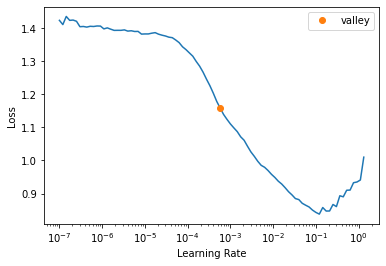

In [ ]:
# find an optimal learning rate
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.739512,0.486993,0.499068,00:03
1,0.618450,0.412889,0.638366,00:03
2,0.545079,0.569353,0.314633,00:03
3,0.505796,0.754437,-0.234789,00:03
4,0.488696,0.596013,0.246222,00:03
5,0.454473,0.579898,0.294211,00:02
6,0.437242,0.412642,0.639260,00:03
7,0.422460,0.527177,0.416265,00:02
8,0.448140,0.385768,0.686572,00:03
9,0.432839,0.430445,0.608631,00:03


You just trained a deep convolutional neural network, from scratch, on a small data set of 1179 images! And this model can perform pretty well: $R^2 \approx 0.79$ and a validation RMSE loss of about $0.31$ dex. Note that your results might vary a bit.

Compare this with our previous machine learning results, which required *UV-optical* colors and several hand-crafted features. We found that a polynomial model could achieve $R^2=0.79$ and RMSE of 0.29 dex. Note that the UV information is particularly key for predicting gas content, and we're not even using it in the CNN model! 

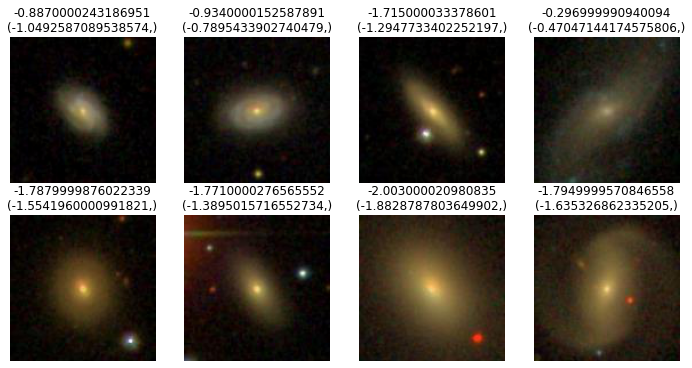

In [ ]:
# visualize our results
learn.show_results(max_n=8, ncols=4)

Our CNN reads in the images *directly*, and outputs a predicted gas mass fraction for each galaxy.

# Understanding convolutions

A picture tells a thousand words, and an animation tells... a lot of pictures?

<!-- ![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif) -->
![](http://media5.datahacker.rs/2020/12/movie1-1-1.gif)

Convolutions can also be computed as matrix multiplications:
![](https://miro.medium.com/max/700/1*9ngOwG-uHaJO8Od0ePB-fQ.jpeg)

This is an important computational point, and highlights why GPUs have accelerated deep learning tremendously in the past decade. GPUs are capable of running many matrix multiplication operations in parallel, so convolutions (as well as other neural network components) can be run extremely quickly.

## A sequence of convolutional layers

![Credit: https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/](https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg)

Just as we can think about images in the RGB channels, or astronomical images with $F606W$ + $F814W$ channels, which are *filtering color information* in the spectrum of galaxies based on their stellar or nebular gas content or whatever, we can think of a convolutional *layer* as containing multiple *filters* that each correspond to different pieces of information. Each filter tries to search out some combination of color and morphology -- like edges, wavelet patterns, etc.

The next layer of the CNN then acts on top of these outputs, or *activation maps*. That is, they take the previous layer's output as input, and then search for higher-level (or more complex) morphological features. For example, multiple edges at different angles can be used to detect curves, and different kinds of wavelets might be combined to identify textured patterns.

In functional form, a neural network might look something like this:

$$ {\rm CNN}(x) = {\rm Layer_{\rm final}} \Big [ \cdots \Big ( {\rm Layer_2} \big ( {\rm Layer}_1(x) \big ) \Big) \Big ], $$

where each layer might contain a convolutional layer and other ingredients (see section below).

## Visualizing learned convolutional filters
A particularly useful way to investigate what a trained CNN has learned is by looking at the kinds of images that are "activated" -- or produce high-valued outputs -- for different convolutional filters. [Zeiler & Fergus (2013)](https://arxiv.org/abs/1311.2901) wrote a paper looking into the kinds of filters that a CNN learned from a popular data set called ImageNet. (This paper has also received 12000 citations...)

![](https://jithinjk.github.io/blog/images/loss_visualize/12.png)
![](https://jithinjk.github.io/blog/images/loss_visualize/3.png)
![](https://jithinjk.github.io/blog/images/loss_visualize/45.png)

In layers 2-5, you can see the filters (left) and the kinds of images that activated those filters (right).


## Demos

To get a feel for how multiple convolutional layers work, try out these demos:
- [MNIST handwritten digit classifier](http://www.cs.cmu.edu/~aharley/vis/conv/flat.html)
- [CNN in a spreadsheet!](https://docs.google.com/spreadsheets/d/1FynckVJJbCzpu8RVRxGPKtnlCPYtDnam3vZGYdbcKB4/edit?usp=sharing)

# Other neural network ingredients

## Activation functions
It turns out that we can't simply chain together multiple convolutional layers. Why? Well the rules of linear algebra state that the product of any number of matrices can be represented by yet another matrix. If you want something that's not represented by just a single matrix, you need a **non-linear function** in between neural network layers.

These are sometimes called **activation functions** because of the way that we expect neurons to get activated.

![](https://www.jeremyjordan.me/content/images/2018/01/Neuron_Hand-tuned.png)
![](https://www.jeremyjordan.me/content/images/2018/01/single_neuron.jpg)


## Batch Normalization

Due to memory constraints, we need to feed in images one "batch" at a time. The number of images is often called the "batch size". Let's suppose we use a batch size of 64.

Images flow through the network one batch at a time, so the inputs should be arrays of size $(N_{\rm batch\ size}, N_{\rm filters}, N_{\rm height}, N_{\rm width})$. In other words, a batch of three-color $120 \times 120$ images has the array shape $(64, 3, 120, 120)$.

*Batch normalization* is a mechanism that keeps the distribution of activations close to a Gaussian distribution. It does this by subtracting the mean and dividing by the standard deviation of its inputs, and is usually inserted before the activation function layer.

## Pooling Layers

Later throughout the CNN, more filters (aka channels) are needed to represent the different kinds of morphological features that might be seen in an image. However, the size of the data that flows through is still of shape $(N_{\rm batch\ size}, N_{\rm filters}, N_{\rm height}, N_{\rm width})$, and we still need to multiply these by the parameters of the neural network!

To lessen the computational burden, we rely on pooling layers: *max pooling* and *mean pooling* are commonly seen. If you double the number of filters, but halve the height and width of the output image by using max pooling with a $2\times 2$ kernel, then you still have fewer outputs than from the preceding layer!

## Fully connected layers

What happens towards the end of a CNN, after all of the convolutional layers? We have a bunch of activation maps, let's say, 512 of these activation maps which are each $7 \times 7$ pixels. We can *flatten* them into 1-d vectors with $512 \times 7 \times 7 = 25,088$ elements. (*Note. This is just an example number.*)

These 25,088 numbers can be used to describe any galaxy image, and you might think of them as some complicated, high-dimensional, feature vector. They can be fed into another in order to predict the logarithmic gas mass fraction -- just as we previously used the 6-dimensional feature vector containing $NUV-r$ color, axial ratio, $r$-magnitude, half-light radius, concentration index, and inclination. We could even use a polynomial model or random forest model again. 

Instead, we'll use *fully connected* layers (aka *dense* or *linear* layers). If you're confused about the name, just remember that we could represent convolutions with *sparse* matrix multiplications; now, we are performing dense matrix multiplication.

We might want to consolidate our 25,088 numbers into a smaller number (let's go with 512) of features, and then finally use those 512 features to directly predict a single quantity: $\log (M_{\rm HI}/M_\star)$. These can each be represented as matrix multiplication using fully connected layers.

## The forward pass

So far we've only been describing the forward pass of the model. Basically, we can assume that we have a model that takes input images, and then outputs a single number (per image): the gas mass fraction.

This can be done even if the model isn't trained yet. That just means that the outputs turn out to be rather bad predictions. In the section below (Optimization), we will see how these outputs can be compared to the targets (aka labels), and then we can optimize the model in order to make it better. 

# A simple CNN model in action (forward)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # the first convolutional layer, followed by batch normalization, 
        # and then the ReLU activation function
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # second convolutional layer has a similar sequence
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # the final fully connected layer is a bit different
        self.fc = nn.Sequential(
            AdaptiveAvgPool(4),   # creates a 64x4x4 max pooling layer
            nn.Flatten(),         # unravels the outputs
            nn.Linear(64*4*4, 1)  # just a matrix multiplication
        )

    # this is the forward pass!
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.fc(out)
        return out

In [ ]:
# create an instance on CPU
model = SimpleNet()

# send to GPU
model.to('cuda')

SimpleNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): AdaptiveAvgPool2d(output_size=4)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
# evaluation mode means that we won't be updating the model, and therefore 
# don't need to keep track of how the model was incorrect.
m = model.eval()

Let's feed it some data! We can grab a single batch using `dls.one_batch()`. This provides
- `xb`, a batch of images of size ($N_{\rm batch\ size}, N_{\rm channels}, N_{\rm height}, N_{\rm width}$)
- `yb`, a batch of logarithmic gas mass fractions of size ($N_{\rm batch\ size}$)

In [ ]:
# a batch of data (note that fastai has placed these on the GPU for us already)
xb, yb = dls.one_batch()

xb.shape, yb.shape

(torch.Size([64, 3, 120, 120]), torch.Size([64]))

In [ ]:
# feed through first layer
after_first_layer = m.conv1(xb)
after_first_layer.shape

torch.Size([64, 32, 60, 60])

In [ ]:
# feed through second layer
after_second_layer = m.conv2(after_first_layer)
after_second_layer.shape

torch.Size([64, 64, 30, 30])

In [ ]:
# feed through first part of the fully connected sequence
after_averagepool = m.fc[0](after_second_layer)
after_averagepool.shape

torch.Size([64, 64, 4, 4])

In [ ]:
# flattening simply changes the shape from 64x4x4 -> 1024
after_flatten = m.fc[1](after_averagepool)
after_flatten.shape

torch.Size([64, 1024])

In [ ]:
# finally perform a matrix multiplication (linear layer)
after_linear = m.fc[2](after_flatten)
after_linear.shape

torch.Size([64, 1])

In [ ]:
# move from GPU back to CPU, and "detach" -- i.e., don't automatically 
# compute gradients (we'll get to this later)
predictions = after_linear.detach().cpu().flatten()
labels = yb.detach().cpu()

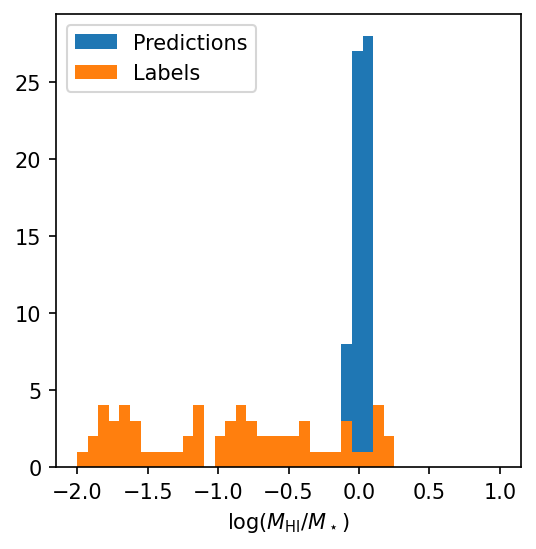

In [ ]:
# compare outputs with ground truths
plt.figure(figsize=(4,4), dpi=150)

plt.hist(predictions, bins=40, range=(-2, 1), label='Predictions')
plt.hist(labels, bins=40, range=(-2, 1), label='Labels')

plt.xlabel(r'$\log(M_{\rm HI}/M_\star)$')
plt.legend();

Text(0.5, 1.0, 'RMSE = 1.13 dex')

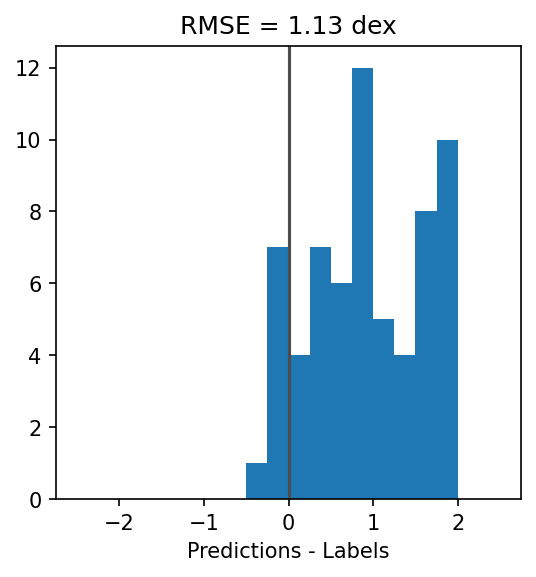

In [ ]:
# how wrong are we?
plt.figure(figsize=(4,4), dpi=150)

plt.hist(predictions - labels, bins=20, range=(-2.5, 2.5))
plt.axvline(0, c='0.3')

plt.xlabel(r'Predictions - Labels')

plt.title(f'RMSE = {((predictions - labels)**2).mean()**0.5:.2f} dex')

# Optimization

Great, we now know how to pass images forward through a model, and get some garbage-quality outputs.

But how do we make our model better? The whole point of machine learning is to let the model learn from examples, and eventually give you a better predictions!

## Loss function

In order to understand what it means for a model to do better, we first need to define what "better" means. In this case (regression on a single target), it's very easy. We've already talked about a loss function: the **root mean squared error (RMSE)**.

We want to minimize the RMSE as a function of the model parameters, given the data examples. Whenever we perform a minimization of a function $J$, given the data $x$, we simply need to find the values of model parameters $\theta$ that set its derivative to zero: $\nabla_\theta J(\theta; x) = 0$.

In practice, optimizing the loss function can be quite difficult. Neural networks are basically never convex functions, which means that you may not find a good solution (depending on your starting point). The loss function forms a high-dimensional surface, which I like to call a loss landscape -- this landscape might be riddled with saddle points and bad local minima, and so you need to find a way to iteratively update your model such that it gives better predictions.

If you want to see a glimpse of the kinds of topologies that these loss landscapes create, check out [this video](https://www.youtube.com/watch?v=As9rW6wtrYk) or the image below:
![](https://www.cs.umd.edu/~tomg/img/landscapes/noshort.png)


## Gradient descent

The gradient, $\nabla_\theta J(\theta; x)$, points in the direction (in our model parameter space) that corresponds to lower loss. That is, it tells us better values of our model parameters $\theta$ in order to improve predictions. This method is called **gradient descent**.

There's just a few problems. First, we'll be sampling different batches of data at a time, and the loss landscape actually depends on which batch of data $x$ we use! So the loss landscape is constantly shifting! (Note that this means we're actually doing *stochastic* gradient descent.) Second, computing the gradient only tells us the *local* direction of steepest descent, but it doesn't actually illustrate the entire loss landscape. If it's like descending down a mountain top, all we know is our current altitude (i.e. our loss), and the direction where we may want to go; we can take a step in that direction and then check our altitude after that step.

The smoothness of our loss landscape matters a lot here. If it's super bumpy, then the direction of steepest descent might vary wildly. This is a challenging problem for optmization. One of the ways to smooth the trajectory of our steps is by using an **adaptive** approach (see section on *Adam* below).



## Backpropagation of error

A third problem might not be immediately obvious: our model parameters actually depend *on each other*. If we want to update our model in the final fully connected layer of the neural network, then it also means that we'll have to tweak model parameters in the previous layer, which then connect to the model parameters in the layer before, and etc. Fortunately, this is computationally tractable and done automatically by `Pytorch`. Indeed, propagating the gradient is just called the *chain rule for derivatives*.

`Pytorch` provides everything we need for computing gradients throughout the model. Even making updates to the model is easy:

$$ \theta_{i+1} = \theta_i - \alpha \nabla_{\theta{_i}} J_i,$$

where $\alpha$ is the step size in the model parameter space, or **learning rate**, but we will discuss that in a section  below. $J$ is the RMSE loss function (in this case). Note that we use a negative sign, because we're trying to minimize the loss.

## Preventing overfitting and improving optimization

After a large number of updates, we might find that our gradient descent algorithm is able to approach the minimum of the loss surface. Remember that we don't necessarily the *global minimum* here: that is impossible because our surface constantly changes with different batches of data, and besides, we might start overfitting.

There are lots of ways, qualitatively, to prevent overfitting. One is to design a model that smooths over all the sharp edges in the model. For example, a popular CNN architecture is called the [ResNet architecture](https://arxiv.org/abs/1512.03385), and it introduces "skip connections" that make the loss landscape much nicer (and neural network optimization much, much better; Figure from [this paper](https://arxiv.org/abs/1712.09913)):
![](https://jithinjk.github.io/blog/images/loss_visualize/loss_1.png)

There are lots of other methods for preventing overfitting. One method called **Dropout** borrows from the idea of random forests: while any highly optimized model might be prone to overfit, a random ensemble of slightly less optimized models might be a lot better for generalization. It does this by randomly setting neurons in the final layers of the CNN to zero, which forces the network to learn redundant pathways for arriving at a good prediction.



## Data augmentation

One way to improve generalization in our image data set is to leverage symmetries. For example, horizontal and vertical flips, and rotations of 90, 180, and 270 degrees can improve the number of images by a factor of eight! (This is called the $D_4$ dihedral group, in case you care about group theory...)

There are other ways to "augment" our data set, for example, by also leveraging (approximate) translational invariance, but we don't do that here.

# The simple CNN model in action (forward + backward)

## Load data and model

In [ ]:
# re-initialize our simple model
model = SimpleNet()
model.to('cuda');

In [ ]:
# the oppposite of "eval" model is "train mode" -- let's ensure we're in 
# training mode, where Pytorch will keep track of gradients
model.train();

In [ ]:
# initialize the loss
train_loss = 0

In [ ]:
# get the first (or next) batch 
xb, yb = next(iter(dls.train))

xb.shape, yb.shape

(torch.Size([64, 3, 120, 120]), torch.Size([64]))

In [ ]:
# this should already be on the GPU
xb.device

device(type='cuda', index=0)

## The forward pass (again)

In [ ]:
# make a (very bad) prediction as before
prediction = model(xb)

prediction.shape

torch.Size([64, 1])

In [ ]:
# define our loss function
def RMSE(p, y): 
    """Square root of the flattened mean squared error loss"""
    return torch.sqrt(MSELossFlat()(p, y))

In [ ]:
# evaluate the loss 
loss = RMSE(prediction, yb)

loss

TensorBase(1.1910, device='cuda:0', grad_fn=<AliasBackward>)

In [ ]:
# keep track of the loss
train_loss += loss.item()

## The backward pass 

In [ ]:
# initialize our optimizer (we'll use stochastic gradient descent for now)
# - it needs to be passed the model parameters in order to update them
# - we will use a value of 0.01 for the learning rate, but we'll discuss this more later
optimizer = SGD(model.parameters(), lr=0.01)

In [ ]:
# remove any previous gradients
optimizer.zero_grad()

In [ ]:
# perform the backwards pass (and thus compute all gradients -- thanks Pytorch!)
# note that gradients are attached to the model parameters
loss.backward()

In [ ]:
# update model parameters
optimizer.step()

Yay! We've done a single update of our neural network! Usually we will keep passing training data through until we've fully completed a run through the entire training sample. Then, we will check how well we did on the validation set.

## Putting it all together: one epoch of training and validation

In [ ]:
# initialize model, optimizer, etc.
model = SimpleNet()
model.to('cuda')

optimizer = SGD(model.parameters(), lr=0.01)

# train
# =====
model.train()
train_loss = 0

# continue grabbing batches of training data
for xb, yb in iter(dls.train):   
    prediction = model(xb)
    loss = RMSE(prediction, yb)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# validate
# ========
valid_loss = 0

# no need to compute gradients, since we're not trying to update the model
with torch.no_grad():  
    model.eval()
    for xb, yb in iter(dls.valid):   
        prediction = model(xb)
        loss = RMSE(prediction, yb)
        valid_loss += loss.item()

# see how well we did
train_loss = train_loss / len(dls.train)
valid_loss = valid_loss / len(dls.valid)

print(f'Train: {train_loss:.4f}      Valid: {valid_loss:.4f}')



Train: 0.8218      Valid: 1.1065


## (*Practice*) Multiple epochs of training 

In [ ]:
# keep track
train_losses = [train_loss]
valid_losses = [valid_loss]

# iterate through more training
for epoch in range(1, 21):

    model.train()
    train_loss = 0
    for xb, yb in iter(dls.train):   
        prediction = model(xb)
        loss = RMSE(prediction, yb)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    valid_loss = 0
    with torch.no_grad():  
        model.eval()
        for xb, yb in iter(dls.valid):   
            prediction = model(xb)
            loss = RMSE(prediction, yb)
            valid_loss += loss.item()

    # we typically normally the loss by the number of batches
    train_loss = train_loss / len(dls.train)
    valid_loss = valid_loss / len(dls.valid)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch:2d}    Train: {train_loss:.4f}      Valid: {valid_loss:.4f}')


Epoch:  1    Train: 0.7230      Valid: 0.9177
Epoch:  2    Train: 0.7277      Valid: 0.7515
Epoch:  3    Train: 0.6495      Valid: 0.6597
Epoch:  4    Train: 0.6484      Valid: 0.5724
Epoch:  5    Train: 0.5981      Valid: 0.6466
Epoch:  6    Train: 0.5912      Valid: 0.4487
Epoch:  7    Train: 0.5407      Valid: 0.5391
Epoch:  8    Train: 0.4659      Valid: 0.8047
Epoch:  9    Train: 0.5736      Valid: 0.5952
Epoch: 10    Train: 0.5346      Valid: 0.5873
Epoch: 11    Train: 0.5321      Valid: 0.4852
Epoch: 12    Train: 0.5347      Valid: 0.5500
Epoch: 13    Train: 0.4774      Valid: 0.4075
Epoch: 14    Train: 0.4956      Valid: 0.5894
Epoch: 15    Train: 0.5185      Valid: 0.6137
Epoch: 16    Train: 0.5172      Valid: 0.5223
Epoch: 17    Train: 0.4834      Valid: 0.3663
Epoch: 18    Train: 0.4733      Valid: 0.5580
Epoch: 19    Train: 0.5022      Valid: 0.4143
Epoch: 20    Train: 0.4485      Valid: 0.4822


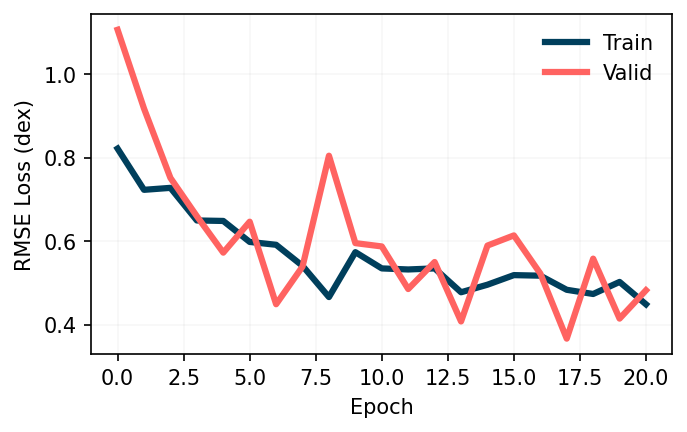

In [ ]:
plt.figure(figsize=(5, 3), dpi=150)
plt.plot(range(0, 21), train_losses, c='#003f5c', lw=3, label='Train')
plt.plot(range(0, 21), valid_losses, c='#ff6361', lw=3, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss (dex)')

plt.legend(framealpha=0)
plt.grid(alpha=0.1)

# Hyperparameters and expediting the optimization

## Learning rate

The learning rate is the most important hyperparameter for *efficiently* training a neural network. It determines how large each update is -- you can think of it as the coefficient to the gradient that is computed from the loss function. For example, a 1-dimension loss landscape $J(\theta)$ is shown below, while gradients multiplied by the learning rate are shown as red arrows:

![](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

We want to make sure that we select an optimal learning rate! There's a nice empirical method for doing this described by [Leslie Smith](https://arxiv.org/pdf/1506.01186.pdf) (and implemented in [Fastai](https://docs.fast.ai/callback.schedule.html#Learner.lr_find)).

## Weight decay

Regularization techniques mitigate overfitting by preventing the model from becoming overly dependent on just a few neurons in the network. Weight decay is a form of regularization related to (and sometimes misconstrued as) L2 regularization -- a method for penalizing extremely large neural network weights:

$$ J(\theta) = {\rm RMSE} + \frac{1}{2} \lambda ||\theta||^2,$$

where $\lambda$ is the weight decay coefficient and $\theta$ are the values of the network's weights.

Note that weight decay can sometimes clash with adaptive gradient descent methods (e.g., Adam, which is described below) and with batch normalization (introduced above). The respective solutions are to use [weight decay-decoupled Adam (AdamW)](](https://arxiv.org/abs/1711.05101)) and [to not use weight decay in any layer preceding batch normalization](](https://blog.janestreet.com/l2-regularization-and-batch-norm/)) (i.e., convolutional layers).



## Gradient descent with Momentum and adaptive momentum (Adam)

Stochastic gradient descent (SGD) is a nice straightforward method for maneuvering about the loss landscape and updating the neural network. A **momentum** term is commonly added: it simply keeps track of previous update directions, and includes a small contribution from those prior steps in the update rule:

$$ \mu_{i+1} = \beta \mu_i + \nabla J(\theta_i) $$
$$ \theta_{i+1} = \theta_i - \alpha \mu_{i+1}$$

If you take a look at many time steps, you'll find that the updates look like:

$$ \theta_{i+1} = \theta_{i} - \alpha \Big [ \nabla J(\theta_{i})  + \beta \nabla J(\theta_{i-i}) + \beta^2 \nabla J(\theta_{i-2}) + \beta^3 \nabla J(\theta_{i-3}) + \cdots \Big ]. $$

The second term looks like the Taylor expansion of an exponential function, and that's what it is sometimes referred to as an *exponentially decaying average* or *exponentially-weighted moving average* (EMA) of the gradient. If you set the hyperparameter $\beta$ to zero, we simply go back to gradient descent. A common choice for momentum is around $\beta = 0.99$.

A good way to gain intuition for how momentum works is by playing with [this awesome demo from distill.pub](https://distill.pub/2017/momentum/). The dynamics of adding momentum to gradient descent are like that of a ball rolling down a hill -- or loss landscape.

**Adam** makes it so that the dynamics are like that of a ball *with friction* rolling down a hill. It can also be described as a simply modification of gradient descent, e.g., [here](https://ruder.io/optimizing-gradient-descent/index.html#adam). Adam has been marketed as a "just plug it in and forget about it" optimizer since it should adapt well to a variety of optimization problems (and while people have found notable instances where it doesn't work as well as SGD, the [original Adam paper](https://arxiv.org/abs/1412.6980) has managed to rack up >70k citations...)

Even more recently, there have been new optimizers such as *RAdam* and *LookAhead*. These have been combined, along with other nice features, in a new optimizer called [**Ranger**](https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer). I've found Ranger to work extraordinarily well in practice on astronomical computer vision tasks.

## Learning rate schedules

You may be wondering whether it makes sense to use a constant learning rate over the entire duration of training. Indeed, it doesn't make sense to take large steps towards the beginning of training when we're far away from a good model, and then continue taking large steps even as we're very close to an optimal region. Rather, we should decrease the learning rate over time, so as to make sure we are carefully descending into the local minima.

This is often implemented by changing the learning rate according to some schedule (often with a functional form). The default schedule is constant over time. Early practioners often used a method of decreasing the learning rate by a factor of 10 every 30 epochs of training (i.e., once convergence is achieved at a given learning rate) --  this allows the network to continue fitting. There are more sophisticated learning rate schedules, e.g.,: 
- a decreasing function in the shape of a cosine (sometimes called cosine annealing)
- a flat rate + cosine function
- a function that first increases (called the warm-up phase) and then decreases (the annealing phase)

Fastai implements the latter two methods, which have been shown to achieve ["super-convergence"](https://sgugger.github.io/the-1cycle-policy.html) -- extremely rapid convergence because of optimization at very high learning rates. These are implemented in the CNN `Learner` object as `fit_flat_cos()` and `fit_one_cycle()` functions.

## Improving the CNN model

We've already suggested that a CNN can benefit from batch normalization, skip connections, and a good choice of activation function. The original ResNet can be improved by adding [several small number of tweaks](https://arxiv.org/abs/1812.01187), and possibly by including other design choices. For example, the [Mish](https://arxiv.org/abs/1908.08681) or [SiLU](https://paperswithcode.com/method/silu) activation functions tend to produce more smooth loss landscapes than the oft-used ReLU (which is discontinuous in its first derivative). [Self-attention](https://arxiv.org/abs/1805.08318) can also be added after convolution layer activations to model *long-range* dependencies of morphological features.

# And that's it!

Now that we've covered everything, go back to the top and re-run the code. There are some specifics about the Fastai `DataBlock` and `DataLoaders` objects that can be read about in their documentation, or in a [blog post here](https://jwuphysics.github.io/blog/galaxies/astrophysics/deep%20learning/computer%20vision/fastai/2020/05/26/training-a-deep-cnn.html#Organizing-the-data-using-the-fastai-DataBlock-API).

# Bonus: a classification task

In [ ]:
!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

# note that there's an updated data set, but it's way bigger (2.5 GB)
# !wget https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

--2022-10-13 18:01:56--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  91.4MB/s    in 2.2s    

2022-10-13 18:01:58 (91.4 MB/s) - ‘Galaxy10.h5’ saved [210234548/210234548]



In [ ]:
from fastai.basics import *
from fastai.vision.all import *

import h5py
from torchvision import transforms

## Examine data

In [ ]:
with h5py.File('Galaxy10.h5', 'r') as f:
    images = np.array(f['images'])
    labels = np.array(f['ans'])

In [ ]:
images.shape, labels.shape

((21785, 69, 69, 3), (21785,))

In [ ]:
Galaxy10Class = {
    0: 'Disk, Face-on, No Spiral',
    1: 'Smooth, Completely round',
    2: 'Smooth, in-between round',
    3: 'Smooth, Cigar shaped',
    4: 'Disk, Edge-on, Rounded Bulge',
    5: 'Disk, Edge-on, Boxy Bulge',
    6: 'Disk, Edge-on, No Bulge',
    7: 'Disk, Face-on, Tight Spiral',
    8: 'Disk, Face-on, Medium Spiral',
    9: 'Disk, Face-on, Loose Spiral'
}

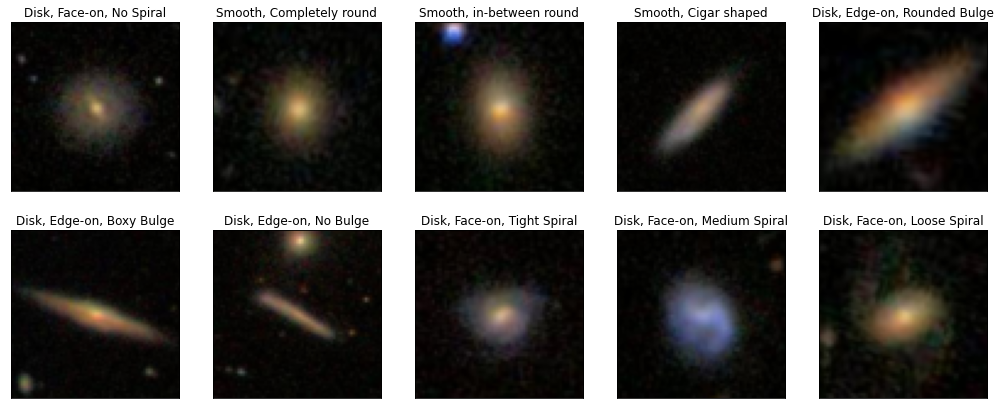

In [ ]:
nrows = 2
ncols = 5
subsize = 3.5
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*subsize, nrows*subsize))

for idx, ax in zip(range(10), axes.flat):
    # pick random instance of class
    locs_in_class = np.where(labels==idx)[0]
    loc = np.random.choice(locs_in_class)

    im = images[loc].astype(int)
    label = Galaxy10Class[labels[loc]]
    ax.imshow(im)

    ax.set_title(label)

    ax.set_xticks([])
    ax.set_yticks([])

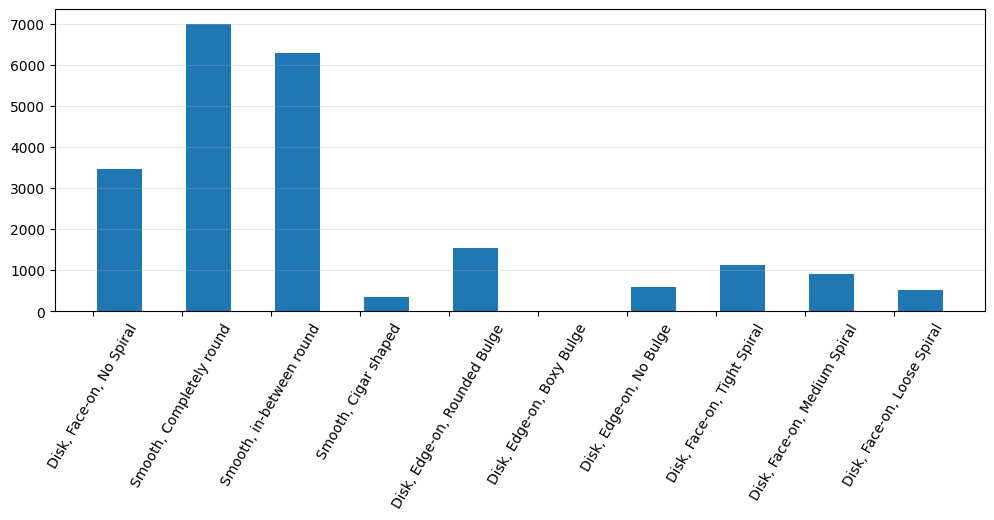

In [ ]:
counts = np.array([sum(labels==idx) for idx in range(10)])

plt.figure(figsize=(12, 4), dpi=100)
plt.bar(range(10), counts, width=0.5)
plt.xticks(np.arange(10)-0.3, Galaxy10Class.values(), rotation=60);
plt.grid(axis='y', alpha=0.3)
# plt.yscale('log')


## Create a Pytorch Dataset

In [ ]:
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, tfms=None):
        self.data = (np.array(data) / 255.).astype(np.float32)
        self.target = np.array(target, dtype=int)
        self.tfms = tfms
        self.vocab = Galaxy10Class
        self.c = len(np.unique(self.target))
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.tfms:
            x = self.tfms(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
# train-validation split (80%/20%)
np.random.seed(42)

N = len(images)
indices = np.random.permutation(N)
train_idxs = indices[:int(0.8*N)]
valid_idxs = indices[int(0.8*N):]

In [ ]:
# data augmentations
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
])

train_ds = GalaxyDataset(images[train_idxs], labels[train_idxs], tfms)
valid_ds = GalaxyDataset(images[valid_idxs], labels[valid_idxs], tfms)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
batch_size = 128
num_workers = 8
num_classes = len(np.unique(labels))

dls = DataLoaders.from_dsets(
    train_ds, 
    valid_ds, 
    bs=batch_size, 
    num_workers=num_workers, 
    device='cuda'
)

In [ ]:
# retrieve a batch and check the sizes (128 images and 128 labels)
x_batch, y_batch = dls.one_batch()

x_batch.shape, y_batch.shape

(torch.Size([128, 3, 69, 69]), torch.Size([128]))

## (*Practice*) Training with a resnet

In [ ]:
learn = vision_learner(
    dls,
    xresnet18,
    pretrained=False,
    loss_func=CrossEntropyLossFlat(),
    opt_func=ranger,
    metrics=[accuracy]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 69 x 69)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 35 x 35  
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 35 x 35  
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 18 x 18  
MaxPool2d                           

SuggestedLRs(valley=0.0030199517495930195)

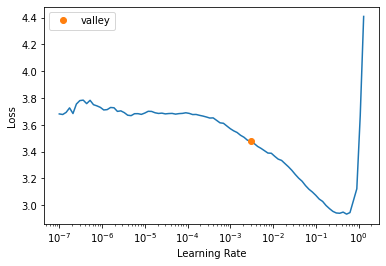

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(20, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,1.359851,1.431288,0.573330,00:14
1,0.932120,1.152973,0.541657,00:14
2,0.849653,0.612872,0.777370,00:14
3,0.726370,1.667877,0.383980,00:14
4,0.662583,1.117003,0.702089,00:14
5,0.651434,0.554634,0.796879,00:14
6,0.600487,0.826379,0.712417,00:14
7,0.585937,0.944934,0.694285,00:14
8,0.573935,0.450636,0.837044,00:14
9,0.555023,0.733839,0.750287,00:14


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

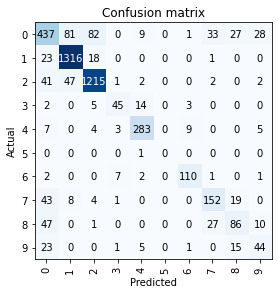

In [ ]:
interp.plot_confusion_matrix()

## (*Practice*) Training with a custom CNN model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            AdaptiveConcatPool2d(1), # creates a 128-element average pooling layer and 128-element max pooling layer
            Flatten(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        return self.fc(out)

In [ ]:
# test that this works
model = SimpleCNN().to('cuda')
model(x_batch).shape

torch.Size([128, 10])

In [ ]:
learn = Learner(
    dls,
    model,
    loss_func=CrossEntropyLossFlat(),
    opt_func=ranger,
    metrics=[accuracy]
)

In [ ]:
learn.summary()

SimpleCNN (Input shape: 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 32 x 32  
Conv2d                                    896        True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 16 x 16  
Conv2d                                    18496      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 128 x 8 x 8   
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                                                           
AdaptiveAvgPool2d                                  

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0008317637839354575)

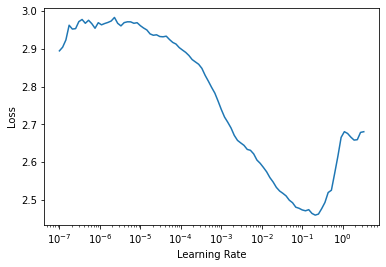

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.547693,1.525709,0.471815,00:13
1,1.262851,1.328658,0.533822,00:13
2,1.120395,1.184709,0.597238,00:13
3,1.045983,1.373809,0.561725,00:13
4,0.990192,1.049637,0.653044,00:13
5,0.947160,0.939409,0.676156,00:13
6,0.929231,1.480157,0.543968,00:13
7,0.886285,0.987973,0.662345,00:13
8,0.808007,0.847371,0.719560,00:13
9,0.705027,0.812393,0.725761,00:13


# Bonus: Hello Universe DeepMerge example

See also the following resources...

- [Hello Universe tutorial](https://archive.stsci.edu/hello-universe/deepmerge) (written in TensorFlow/Keras)
- [MAST High Level Science Products](https://archive.stsci.edu/hlsp/deepmerge), which contain the nicely packaged data and documentation
- [Ćiprijanović et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract) (paper)

## Setting up the data set

In [ ]:
from astropy.io import fits
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
!wget --no-clobber https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits

In [ ]:
# organizing the data
with fits.open('hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits') as h:
    X_noisy = h[0].data
    y_noisy = h[1].data

X = tensor(np.asarray(X_noisy).astype('float32'))
y = tensor(np.asarray(y_noisy).astype('float32'))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
# grabbing image statistics for normalization
image_means = X_train[:100].mean(dim=(0, 2, 3))
image_stds = X_train[:100].std(dim=(0, 2, 3))

transforms_train = Pipeline([ToTensor, Dihedral, Normalize.from_stats(image_means, image_stds)])
transforms_valid = Pipeline([ToTensor, Normalize.from_stats(image_means, image_stds)])

In [ ]:
# slight modification to our dataset above
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target.type(torch.LongTensor) # <-- make sure you cast this...
        self.transform = transform
        
        self.c = len(np.unique(target))
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
dset_train = GalaxyDataset(X_train, y_train, transform=transforms_train)
dset_valid = GalaxyDataset(X_valid, y_valid, transform=transforms_valid)

In [ ]:
def norm(vals, vmin=None, vmax=None, Q=8, stretch=None):
    """
    For visualization purposes normalize image with `arcsinh((vals-vmin)/(vmax-vmin)), 
    with vmin and vmax respectively defaulted to 0.01 and 0.99 quantiles of all values. 
    
    Q and stretch control the arcsinh softening parameter, see Lupton et al. 2004 and
    see https://docs.astropy.org/en/stable/_modules/astropy/visualization/lupton_rgb.html#make_lupton_rgb
    """
    if vmin is None: vmin = np.quantile(vals, 0.01)
    if vmax is None: vmax = np.quantile(vals, 0.99)
    
    if stretch is None:
        return np.arcsinh(Q*(vals - vmin) / (vmax-vmin)) / Q
    else:
        return np.arcsinh(Q*(vals - vmin) / stretch) / Q

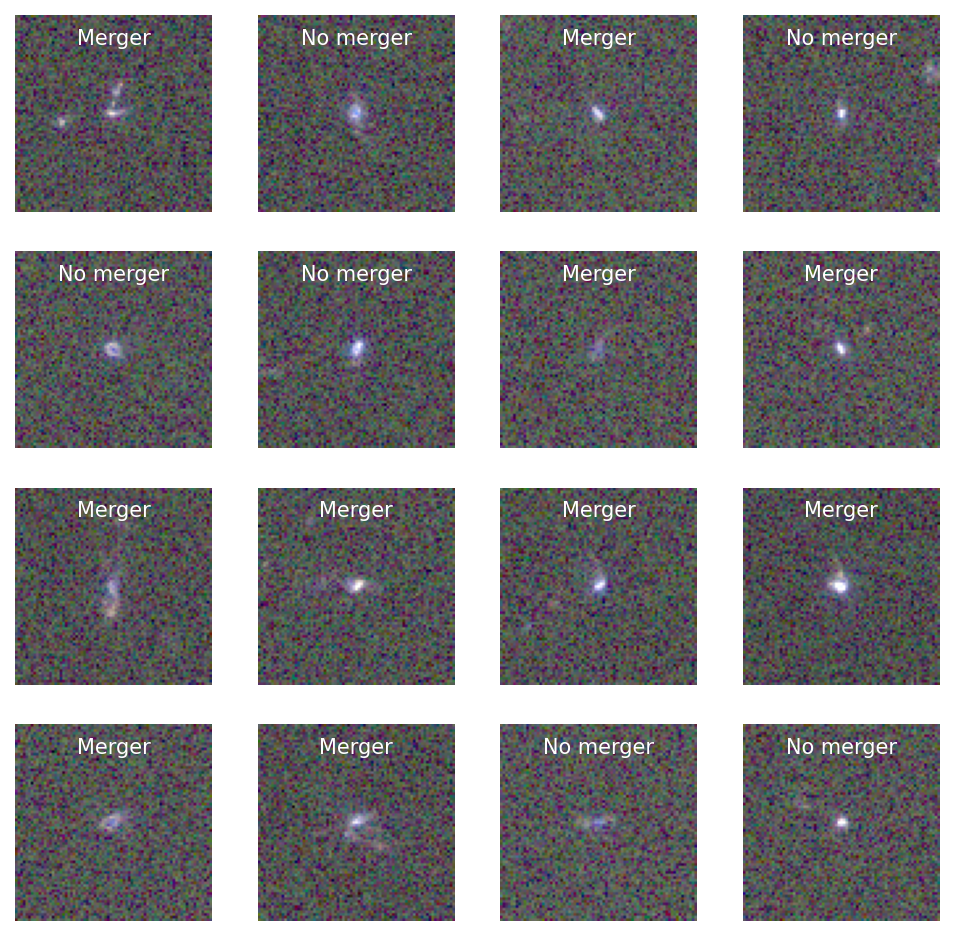

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=150) 

for i, (image, cls) in enumerate(zip(*dset_train[:16])):
    ax = fig.add_subplot(4, 4, i+1)
    
    image = norm(image, Q=4).permute(1, 2, 0).clip(0, 1)

    ax.imshow(image, aspect='equal')
    ax.text(0.5, 0.85, "Merger" if cls == 1 else "No merger", ha='center', color='white', transform=ax.transAxes)
    
    ax.axis('off')
    
plt.show()

## (*Practice*) Setting up the neural network and train the classifier

In [ ]:
dls = ImageDataLoaders.from_dsets(dset_train, dset_valid, device='cuda', bs=64)

In [ ]:
model = resnet18()
model.fc = nn.Linear(in_features=512, out_features=dls.c, bias=True)

learn = Learner(
    dls, 
    model, 
    loss_func=CrossEntropyLossFlat(), 
    opt_func=Adam,
    metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()]
)

learn.cuda();

In [ ]:
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.700061,0.668922,0.587727,0.434944,0.661017,0.524664,0.652160,00:15
1,0.602813,0.750247,0.650389,0.431227,0.812451,0.563411,0.772883,00:15
2,0.542889,0.704983,0.648876,0.372160,0.895626,0.525824,0.807021,00:15
3,0.507846,0.563059,0.718021,0.608839,0.804585,0.693158,0.803405,00:15
4,0.473996,0.568696,0.715428,0.777365,0.707519,0.740799,0.806156,00:15


Evaluate results via confusion matrix

In [ ]:
ps, ys = learn.get_preds()

ps = ps[:, 1].flatten().detach().numpy()
ys = ys.flatten().detach().numpy()

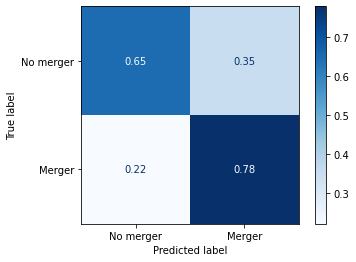

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    ys, 
    ps > 0.5, 
    cmap='Blues', 
    normalize='true', 
    display_labels=['No merger', 'Merger']
);

# Bonus: Fully Connected Neural networks

In [ ]:
df = pd.read_csv('xGASS_representative_sample.csv', index_col='GASS')

In [ ]:
observational_features = ['model_r', 'NUVr']
morphological_features = ['expAB_r', 'petrR50_r', 'CINDX', 'INCL']

features = observational_features + morphological_features
target = ['lgGF']

df[features + target].sample(5, random_state=42)

,model_r,NUVr,expAB_r,petrR50_r,CINDX,INCL,lgGF
GASS,,,,,,,
108064,14.6820,2.30,0.347443,7.51,2.52,73.1,-0.082
3504,15.4495,2.81,0.939227,8.53,1.84,20.5,-0.512
112116,15.1316,1.69,0.614720,3.23,2.42,53.6,-0.682
111013,13.8649,2.71,0.791741,8.47,2.34,38.6,-0.669
52045,15.5552,2.08,0.961924,3.97,2.38,16.2,-0.403


In [ ]:
# we did this last time
df.NUVr = np.where(df.NUVr < -90, df.NUVr.median(), df.NUVr)

## Fastai Data Loader

In [ ]:
dls = TabularDataLoaders.from_df(
    df, 
    cont_names=features, 
    y_names=target, 
    y_block=RegressionBlock
)

In [ ]:
dls.show_batch()

,model_r,NUVr,expAB_r,petrR50_r,CINDX,INCL,lgGF
0,14.8019,3.97,0.659076,3.62,2.66,50.099998,-1.443
1,15.8171,3.25,0.774545,4.05,2.73,40.200001,-0.602
2,14.6308,3.91,0.815461,5.11,2.74,36.200001,-1.705
3,14.7457,6.28,0.491302,3.65,3.18,62.700001,-1.874
4,15.0960,5.30,0.634715,2.30,2.89,52.099998,-1.576
5,15.1712,3.06,0.250041,6.62,2.27,81.199997,-0.529
6,14.9872,2.97,0.594357,5.65,1.97,55.200001,-0.832
7,15.9079,4.61,0.576230,2.52,3.46,56.500000,-1.306
8,15.5523,3.74,0.398082,3.32,2.26,69.400002,-0.973
9,14.6075,2.30,0.657654,8.92,2.00,50.299999,-0.063


## Fastai Learner

In [ ]:
learn = tabular_learner(
    dls, 
    layers=[100, 50], 
    loss_func=RMSE,
    opt_func=ranger,
    metrics=[R2Score()],  
)

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.17378008365631104)

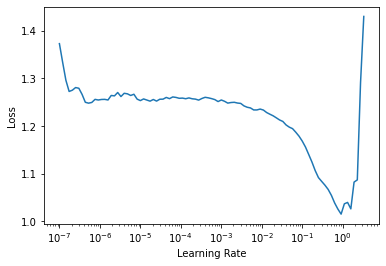

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10, 0.1)

epoch,train_loss,valid_loss,r2_score,time
0,0.809860,0.931568,-1.162644,00:00
1,0.585931,0.379741,0.637902,00:00
2,0.478586,0.345508,0.701022,00:00
3,0.421541,0.302848,0.768286,00:00
4,0.384639,0.400364,0.600544,00:00
5,0.364067,0.312414,0.755380,00:00
6,0.349017,0.306077,0.764325,00:00
7,0.340137,0.331785,0.724339,00:00
8,0.331484,0.289819,0.787540,00:00
9,0.320758,0.283468,0.797157,00:00


We're getting to $R^2 = 0.80$ and $RMSE <0.29$ dex.

## How well do we do if we take away the $NUV-r$ color?

In [ ]:
dls = TabularDataLoaders.from_df(
    df, 
    cont_names=['model_r', 'expAB_r', 'petrR50_r', 'CINDX', 'INCL'], 
    y_names=target, 
    y_block=RegressionBlock
)

In [ ]:
learn = tabular_learner(
    dls, 
    layers=[100, 50], 
    loss_func=RMSE,
    opt_func=ranger,
    metrics=[R2Score()],  
)

In [ ]:
learn.fit_flat_cos(10, 0.1)

epoch,train_loss,valid_loss,r2_score,time
0,0.884182,0.870223,-0.859558,00:00
1,0.707526,0.560251,0.229769,00:00
2,0.639858,0.490358,0.409155,00:00
3,0.597490,0.501961,0.379859,00:00
4,0.573731,0.545996,0.268812,00:00
5,0.558620,0.487961,0.415213,00:00
6,0.544900,0.561713,0.225539,00:00
7,0.545945,0.523546,0.326511,00:00
8,0.540334,0.492393,0.404921,00:00
9,0.531565,0.491656,0.406348,00:00
